---
title: "Unsupervised Learning"
format:
    html: 
        code-fold: false
---

{{< include summary.qmd >}} 

## Code

In [39]:
# General Imports

import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

import plotly.io as pio

# Use pio to ensure plotly plots render in Quarto
pio.renderers.default = 'notebook_connected'

# Dataset Visualization
## Principal Component Analysis
### All Voting Data Visualizations
#### 2-D Visualization

Before we dive into the clustering methods outlined above, we begin by leveraging PCA for dimensionality reduction to explore our voting data in lower dimensions. We do this because we are fortunate enough to have access to the ground truths for each voting outcome, and can plot with outcome labels to see if clusters are naturally present in the data. 

In [47]:
# Load in the data
batter_df = pd.read_csv('../../data/processed-data/batter_df_for_prediction.csv')

# Define the targets, which we will use for coloring plots
str_targets = batter_df.outcome
num_targets = pd.Categorical(batter_df['outcome']).codes

# Filter to only numeric columns, as these are the only plottable ones
numeric_df = batter_df.select_dtypes(include=np.number).drop(columns='votes_pct')

When reducing dimensions, it is often a helpful step to **standardize and/or scale data beforehand**. We do this with scikit-learn's StandardScaler, which scales all features to a more centered distribution with a standard deviation = 1.

This is done by subtracting the mean of the data from each point and dividing by the original standard deviation

In [41]:
# Scale Data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_df)

After scaling the data, we use PCA to reduce the dataset to 2 dimensions.

In [42]:
# Convert to only 2 Dimensions via PCA
pca = PCA(n_components=2)
pca_df = pca.fit_transform(scaled_data)

With this two dimensional dataset, we now plot each data point, with each axis representing an individual principal component.

Text(0, 0.5, 'PCA Component 2')

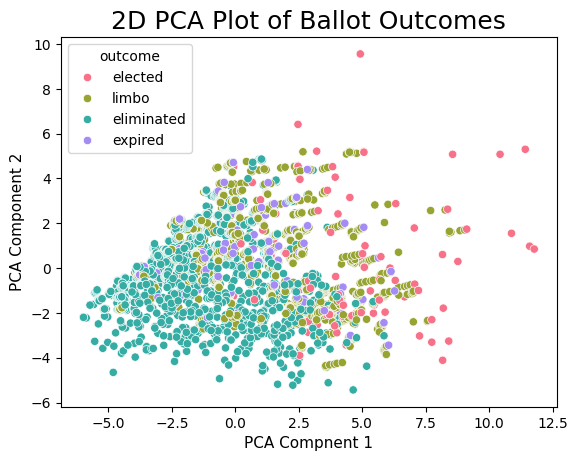

In [43]:
simple = batter_df[['b_war', 'year_on_ballot']]
pca_df = pd.DataFrame(pca_df, columns=['PC1', 'PC2'])

sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue=str_targets, palette="husl")
plt.title("2D PCA Plot of Ballot Outcomes", fontsize=18)
plt.xlabel('PCA Compnent 1', fontsize=11)
plt.ylabel('PCA Component 2', fontsize=11)

Immediately we see some interesting results! While there is still some overlap between the different outcomes, we still do see a clear pattern where as either PCA Components increase, we see that the outcomes send from elimination, to expiration/limbo to elected. This is a fascinating result because this order can generally be thought of as being increasingly good at baseball. Thus, even within the 2-d PCA data, there are clear visual trends separating HOF players from non-HOF players! Additionally, the fact that we see the different groups start to separate tells us that we have a decent shot at being able to **predict whether a player will be elected or not based on their underlying stats.**


#### 3D Visualization

As a next step, we undertake the exact same procedure as before, but this time reduce our data to 3 dimensions, to see if the added dimension is able to help separate different clusters.

In [36]:
# Scale Data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_df)

# Convert to only 2 Dimensions
pca = PCA(n_components=3)
pca_df = pca.fit_transform(scaled_data)

In [37]:
# Create a 3D scatter plot
pca_df = pd.DataFrame(pca_df, columns=['PC1', 'PC2', 'PC3'])

# Scatter plot
# Plotly 3D Scatter plot
fig = px.scatter_3d(pca_df, x='PC1', y='PC2', z='PC3', color=str_targets, hover_name = batter_df.player_id, 
                    title='Scatterplot of BBWAA Voting Data along 3 Principal Components', 
                    labels={'X': 'Principal Component 1', 'Y': 'Principal Component 2', 'Z': 'Principal Component 3'})

fig.show()

Above, we see that the third dimension does indeed help separate our outcome differences! There still remains some significant overlap between the limbo/expired and eliminated outcomes, but the election outcomes have clearly started to separate themselves, giving us even more hope that predicting outcomes is a reasonable task, especially if we limit to predicting a binary election/non-election outcome.

The other interesting result is we see that there are lots of mini **clusters of points each belonging to the same player**. You can see this for yourself by hovering the curser over individual points. This occurs becuase the points for all these players are the same other than an added year, plus an update to the last years voting percentage. As a next step, we look to only plot one point per player, plotting them as elected if they were, or else non elected for any other set of outcomes. While this is not feasable as a prediction method given in real time we never know if it is a player's last year on the ballot, but it is a great exercise in curiosity to see if elected vs non-elected players can be separated visually on the career level.

### Career Voting Visualization

In [38]:
# Subset to only one point per player, ensuring we keep the election outcome if it exists.
batter_df = batter_df.sort_values(by='outcome').drop_duplicates(subset=['name'], keep='first')

# Create a new targets column that is binary for if the player was elected
binary_targets = batter_df.outcome == "elected"

# Define the targets, which we will use for coloring plots
str_targets = batter_df.outcome
num_targets = pd.Categorical(batter_df['outcome']).codes

# Filter to only numeric columns, as these are the only plottable ones
numeric_df = batter_df.select_dtypes(include=np.number).drop(columns='votes_pct')

# Print the number of players in the filtered df
print(f"There are {len(numeric_df)} individual players who have been placed on a ballot")

# Scale Data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_df)

# Convert to only 2 Dimensions
pca = PCA(n_components=3)
pca_df = pca.fit_transform(scaled_data)

# Create a 3D scatter plot
pca_df = pd.DataFrame(pca_df, columns=['PC1', 'PC2', 'PC3'])

# Scatter plot
# Plotly 3D Scatter plot
fig = px.scatter_3d(pca_df, x='PC1', y='PC2', z='PC3', color=binary_targets, hover_name=batter_df.name,
                    title='Scatterplot of Succesful BBWAA Ballot Elections', 
                    labels={'X': 'Principal Component 1', 'Y': 'Principal Component 2', 'Z': 'Principal Component 3'})

fig.show()

There are 781 individual players who have been placed on a ballot


Converting the targets to binary values and limiting the data to only one outcome products two pretty stark groupings of points. What is interesting about the data however is that they are not necessarily two 'distinct' clusters. There is only one cluster of data from a density standpoint, but it contains a somewhat clean barrier between the two classes. As a result, we are unsure if more tradidional clustering methods will be able to succesfully cluster the data in accordance with the ground truths, but we explore the possibilities below.

# t-SNE Visualizations

As a final step before the clustering analysis, we also explore dimensionality reduction via t-SNE. For this we look at the 3 dimensional projection of the data.

In [ ]:
# Reduce dimensions with t-sne
tsne = TSNE(n_components=3, random_state=5000, perplexity=30)
tsne_df = tsne.fit_transform(scaled_data)

# Create a 3D scatter plot
tsne_df = pd.DataFrame(tsne_df, columns=['First Dimension', 'Second Dimension', 'Third Dimension'])

# Scatter plot
# Plotly 3D Scatter plot
fig = px.scatter_3d(tsne_df, x='First Dimension', y='Second Dimension', z='Third Dimension', color=str_targets, 
                    title='Interactive 3D Scatter Plot', 
                    labels={'X': 'First Dimension', 'Y': 'Second Dimension', 'Z': 'Third Dimension'})

fig.show()

In the above t-SNE plot, we see the algorithm does a pretty good job at keeping points of the same outcome in close proximity to one another. This is a good sign for us, becuase the implication is that back in our higher dimensional space, the data of similar classes is close to one another, **leading us once again to believe that predicions of the outcome back in this space is a reasonable exercise**.

# Clustering Analysis
## K-Means
### Optimal Known Clusters

Moving into our clustering analysis, we begin by fitting the K-Means algorithm on our dataset with one point per player. Given we know that there are 4 ground truth outcomes, we start by fitting K-Means with 4 clusters.

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=5000)
kmeans.fit(scaled_data)


labels = kmeans.labels_

cluster_names = {0: 'Cluster 0', 1: 'Cluster 1', 2: 'Cluster 2', 3: 'Cluster 3'}
labels = pd.Series(labels).map(cluster_names)

fig = px.scatter_3d(pca_df, x='PC1', y='PC2', z='PC3', color=labels, 
                    title='K-Means Results with 4 Clusters', 
                    labels={'X': 'Principal Component 1', 'Y': 'Principal Component 2', 'Z': 'Principal Component 3'})

fig.show()

Unsuprisingly, the K-Means algorithm does not fit our data very well. We can see that it pretty equally divides our data into 4 quadrants rather than matching the separations we saw earlier with the ground truths. This is becuase while we saw above the data had some boundries between the outcomes, there were more just boundries than distinct clusters. Without the distinct clustering in the data, K-Means is unable to produce the clusters we are looking for.

### Calculating 'Optimal' Clusters

One way to choose an optimal number of clusters for K-Means is to plot a metric of choice, in this case intertia, for a varying number of clusters. Then the 'optimal' number of clusters becomes the point where the decrease intertia sharply flattens out. This is known as the elbow method. Below, we utilize the elbow method to determine the 'optimal' number of clusters as according to K-Means.

In [ ]:
scores = []
for n in range(2,10):
    kmeans = KMeans(n_clusters=n, random_state=5000)
    kmeans.fit(scaled_data)
    labels = kmeans.labels_

    score = kmeans.inertia_
    scores.append(score)

score_df = pd.DataFrame({'n_clusters':range(2,10), 'scores':scores})

Text(0.5, 1.0, 'KMeans Silhouette Score Elbow Plot')

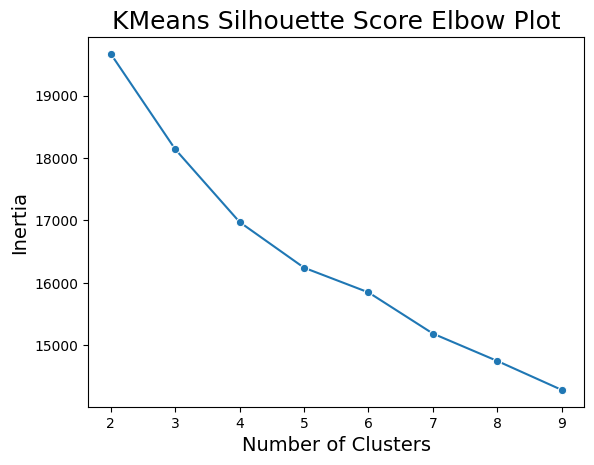

In [ ]:
sns.lineplot(data=score_df, x='n_clusters', y='scores', marker='o')
plt.ylabel('Inertia', fontsize=14)
plt.xlabel('Number of Clusters', fontsize=14)
plt.title('KMeans Silhouette Score Elbow Plot', fontsize=18)

In the elbow chart above, there is not a clear number of clusters to choose as the optimal number. There is some drop off in the decrease in inertia at 5 or 6 clusters, but it is nothing drastic. As such, especially knowing that the true number of outcome classes is 4, **we conclude that K-Means does not produce a good fit for out data.**

## DBSCAN

As a final clustering method to explore, we fit the DBSCAN algorithm to the same dataset as in K-Means, again in 3 dimensions. The results can be seen below:

In [ ]:
dbscan = DBSCAN()
dbscan.fit(scaled_data)

labels = dbscan.labels_

fig = px.scatter_3d(pca_df, x='PC1', y='PC2', z='PC3', color=labels, 
                    title='Scatterplot of BBWAA Voting Data, Clustered with DBSCAN', 
                    labels={'X': 'Principal Component 1', 'Y': 'Principal Component 2', 'Z': 'Principal Component 3'})

fig.show()

We see above that the DBSCAN method produces even worse results than the K-Means. This makes intuitive sense however, as we see that our data has a fairly uniform density, meaning DBSCAN with converge onto one large cluster (given the lack of varying densities). As we did with K-Means, we once again conclude that DBSCAN does not prodive a good fit to our dataset.

# Summary

While the clustering methods did not provide any good fits for our dataset, we did see positive and interesting results with our dimensionality reductions, particularly when paried with ground truth labeling. Because of these positive results, we believe that there is a good possibility we will be able to predict BBWAA voting outcomes with some success! Explanations of these prediction methods, as well as their results can be seen in the next **Supervised Learning** tab.